In [5]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch.nn as nn
import torch_geometric.nn as geom_nn
import copy

In [43]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))



def min_max_scaler(data,train_indices):

    ### Extracting Train Dataset ###
    train_dat = [ data[train_indices[i]] for i in range(len(train_indices)) ]

    ### Extracting Test Dataset ###
    test_indices = np.setdiff1d( np.arange(len(data)) , train_indices  )
    test_dat = [ data[test_indices[i]] for i in range(len(test_indices)) ]

    ### Scaling inputs ###
    ### Getting min and max values ###
    max_vals = np.max(np.stack([train_dat[i].x[:,j].max() for i in 
                                range(len(train_dat)) for j in range(train_dat[i].x.shape[1]) ]).reshape(len(train_dat),train_dat[0].x.shape[1]),axis=0)
    
    min_vals = np.min(np.stack([train_dat[i].x[:,j].min() for i in 
                                range(len(train_dat)) for j in range(train_dat[i].x.shape[1]) ]).reshape(len(train_dat),train_dat[0].x.shape[1]),axis=0)

    
    ### Performing the scaling ###
    train_dat_input = [ (train_dat[i].x - min_vals)/(max_vals - min_vals) for i in range(len(train_dat))] 
    test_dat_input = [ (test_dat[i].x - min_vals)/(max_vals - min_vals) for i in range(len(test_dat))]

    ### Scaling outputs ###
    ### Getting min and max values ###
    max_vals = np.max( np.stack( [train_dat[i].y.max() for i in range(len(train_dat))] ),axis=0)
    min_vals = np.min( np.stack( [train_dat[i].y.min() for i in range(len(train_dat))] ),axis=0)

    ### Performing the scaling ###
    train_dat_output = [ (train_dat[i].y - min_vals)/(max_vals - min_vals) for i in range(len(train_dat))] 
    test_dat_output = [ (test_dat[i].y - min_vals)/(max_vals - min_vals) for i in range(len(test_dat))]

    ### Combine x and y edge indices from the train and test dataset to form a pygnn Data variable ###
    train_combined = list()
    test_combined = list()
    
    for i in range(len(train_dat_input)):

        x = train_dat_input[i].clone()
        edge_index = ( train_dat[i].edge_index ).clone()
        y = (train_dat_output[i]).clone()
        train_combined.append(Data(x=x , edge_index=edge_index , y=y))

    for i in range(len(test_dat_input)):

        x = test_dat_input[i].clone()
        edge_index = ( test_dat[i].edge_index ).clone()
        y = (test_dat_output[i]).clone()
        test_combined.append(Data(x=x , edge_index=edge_index , y=y))

    return train_combined,test_combined

def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))

def add_const_parameter_to_pandas_list(pandas_list, column_name, const_param):
    """
    Given a list of pandas DataFrames, add a constant parameter to the specified column in each DataFrame.
    """
    result = copy.deepcopy(pandas_list)
    
    for i in range(len(result)):
        result[i][column_name] = np.ones(len(result[i])) * const_param
    
    return result

def merge_columns_to_pandas_list(pandas_list,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined = copy.deepcopy(pandas_list)

    for i in range(len(joined)):
        print("Particle number : ",str(i+1))
        
        temp = copy.deepcopy(joined[i])
        add = pd.merge(temp,master_dataframe,how="inner",on=['x','Re'])[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)

        clear_output(wait=True)

    return joined


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 

### Validation ###
# print(all_dat[0].edge_index[:,0:5])
# test = mirror_edge_index(all_dat[0].edge_index[:,0:5].detach().cpu().numpy())
# print(test)

In [111]:
def box_scale(dataframe):

    ## Scales all the x-locations and inlcination based on the previously known min and max vals ###
    scaled = dataframe.copy()

    if any("x" in s for s in scaled.columns):
        scaled["x"] = (scaled["x"]-5)/(15)

    if any("y" in s for s in scaled.columns):
        scaled["y"] = (scaled["y"]+20)/(40)

    if any("z" in s for s in scaled.columns):
        scaled["z"] = (scaled["z"]+20)/(40)
    
    if any("Inclination_angle" in s for s in scaled.columns):
        scaled["Inclination_angle"] = (scaled["Inclination_angle"])/(90)

    if any("Re" in s for s in scaled.columns):
        scaled["Re"] = (scaled["Re"]-10)/(190)

    if any("phi" in s for s in scaled.columns):
        scaled["phi"] = (scaled["phi"]-10)/(20)

    if any("Drag_local" in s for s in scaled.columns):
        scaled["Drag_local"] = (scaled["Drag_local"]-88.25738)/(88.25738 - 2.539126)

    return scaled

In [121]:
df = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)
df = df.rename(columns={'Center_x': 'x', 'Center_y': 'y', 'Center_z': 'z'})
df = box_scale(df)
print(np.unique(df['phi']))
print(np.unique(df['Re']))

[0.  0.5 1. ]
[0.         0.21052632 0.47368421 1.        ]


In [72]:
### Reading Raw Data ###
df = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)
df = df.rename(columns={'Center_x': 'x', 'Center_y': 'y', 'Center_z': 'z'})
all_tags = np.load("ze_tags_2p5.npy")

### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]

all_particles = np.concatenate((center_shifted_10,center_shifted_20,center_shifted_30))

In [73]:
### Generate Dataset for Sf=0.1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10.copy()
dev_particles = center_10_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

### Adding Column for solid fraction ###
input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',0.1)
input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

### Adding 4 Reynolds Numbers and stacking them ###
temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

### Joining all Reynolds numbers ###
input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
input_dat_sf10 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

Particle number :  828


In [74]:
### Generate Dataset for Sf=0.2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20.copy()
dev_particles = center_20_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

### Adding Column for solid fraction ###
input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',0.2)
input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

### Adding 4 Reynolds Numbers and stacking them ###
temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

### Joining all Reynolds numbers ###
input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
input_dat_sf20 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

Particle number :  1608


In [75]:
### Generate Dataset for Sf=0.3 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_30.copy()
dev_particles = center_30_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = [pd.DataFrame(all_particles.iloc[idx[i]]) for i in range(len(idx))]

### Adding Column for solid fraction ###
input_dat = add_const_parameter_to_pandas_list(input_dat,'phi',0.3)
input_dat = [input_dat[i].reset_index(drop=True) for i in range(len(input_dat))]

### Adding 4 Reynolds Numbers and stacking them ###
temp_re10 = add_const_parameter_to_pandas_list(input_dat,'Re',10).copy()
temp_re50 = add_const_parameter_to_pandas_list(input_dat,'Re',50).copy()
temp_re100 = add_const_parameter_to_pandas_list(input_dat,'Re',100).copy()
temp_re200 = add_const_parameter_to_pandas_list(input_dat,'Re',200).copy()

### Joining all Reynolds numbers ###
input_dat = temp_re10 + temp_re50 + temp_re100 + temp_re200
input_dat_sf30 = merge_columns_to_pandas_list(input_dat,["Inclination_angle","Drag_local"],df)

Particle number :  2300


In [76]:
### Combining all the datasets from different solid fractions ###
all_data_pd = input_dat_sf10 + input_dat_sf20 + input_dat_sf30

In [77]:
all_data_graph_struct = list()

edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

for i in range(len(all_data_pd)):

    ### setting inputs ###
    x = torch.tensor(all_data_pd[i][["x","y","z","phi","Re","Inclination_angle"]].values).float()
    
    ### adding drag force as y ###
    y = torch.tensor(all_data_pd[i]["Drag_local"][0][None,None]).float()
    
    all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))


In [78]:
### Define Train Indices and perform scaling ###
check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
          center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
         center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
train_indices = np.setdiff1d( np.arange(len(all_data_graph_struct)) , test_indices )
# train_combined,test_combined = min_max_scaler(all_data_graph_struct,train_indices)
train_combined,test_combined = [ all_data_graph_struct[train_indices[i]] for i in range(len(train_indices)) ],[ all_data_graph_struct[test_indices[i]] for i in range(len(test_indices)) ]

In [98]:
temp = np.array([train_combined[i].y for i in range(len(train_combined))])
temp.max()

88.25738

In [99]:
temp = np.array([train_combined[i].y for i in range(len(train_combined))])
temp.min()

2.539126

In [10]:
# Wrap data in a data loader
NUM_GRAPHS_PER_BATCH = 16

train_loader = DataLoader(train_combined, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

test_loader = DataLoader(test_combined, 
                    batch_size=1, shuffle=False)

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 132

class GCN(torch.nn.Module):
    def __init__(self):
        
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(6, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        # hidden = self.conv3(hidden, edge_index)
        # hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(6, 132)
  (conv1): GCNConv(132, 132)
  (conv2): GCNConv(132, 132)
  (conv3): GCNConv(132, 132)
  (out): Linear(in_features=264, out_features=1, bias=True)
)
Number of parameters:  53857


In [12]:
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F 
# from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
# from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

# gnn_layer_by_name = {
#     "GCN": geom_nn.GCNConv,
#     "GAT": geom_nn.GATConv,
#     "GraphConv": geom_nn.GraphConv
# }

# class GNNModel(nn.Module):

#     def __init__(self, c_in, c_hidden, c_out, num_layers=3, layer_name="GCN", dp_rate=0.05, **kwargs):
        
#         """
#         Inputs:
#             c_in - Dimension of input features
#             c_hidden - Dimension of hidden features
#             c_out - Dimension of the output features. Usually number of classes in classification
#             num_layers - Number of "hidden" graph layers
#             layer_name - String of the graph layer to use
#             dp_rate - Dropout rate to apply throughout the network
#             kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
#         """
        
#         super().__init__()
#         gnn_layer = gnn_layer_by_name[layer_name]

#         layers = []
#         in_channels, out_channels = c_in, c_hidden
        
#         for l_idx in range(num_layers-1):
#             layers += [
#                 gnn_layer(in_channels=in_channels,
#                           out_channels=out_channels,
#                           **kwargs),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(dp_rate)
#             ]
#             in_channels = c_hidden
            
#         layers += [gnn_layer(in_channels=in_channels,
#                              out_channels=c_out,
#                              **kwargs)]
#         self.layers = nn.ModuleList(layers)

#     def forward(self, x, edge_index):
#         """
#         Inputs:
#             x - Input features per node
#             edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#         """
#         for l in self.layers:
#             # For graph layers, we need to add the "edge_index" tensor as additional input
#             # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
#             # we can simply check the class type.
            
#             if isinstance(l, geom_nn.MessagePassing):
                
#                 x = l(x, edge_index)
#                 # print("Message Passing",type(l))
#                 ### Doubt here there is message passing sometimes and not other times ###
            
#             else:
#                 x = l(x)
#                 # print("Not message passing",type(l))
#         return x

In [13]:
# class GraphGNNModel(nn.Module):

#     def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.05, **kwargs):
#         """
#         Inputs:
#             c_in - Dimension of input features
#             c_hidden - Dimension of hidden features
#             c_out - Dimension of output features (usually number of classes)
#             dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
#             kwargs - Additional arguments for the GNNModel object
#         """
#         super().__init__()
#         self.GNN = GNNModel(c_in=c_in,
#                             c_hidden=c_hidden,
#                             c_out=c_hidden, # Not our prediction output yet!
#                             **kwargs)
#         self.head = nn.Sequential(
#             nn.Dropout(dp_rate_linear),
#             nn.Linear(c_hidden*2, 1)
#         )

#     def forward(self, x, edge_index, batch_idx):
#         """
#         Inputs:
#             x - Input features per node
#             edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#             batch_idx - Index of batch element for each node
#         """
#         x = self.GNN(x, edge_index)
#         # x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
#         x = torch.cat([gmp(x, batch_idx), 
#                             gap(x, batch_idx)], dim=1)
#         x = self.head(x)
        
#         return x

# model = GraphGNNModel(c_in=6, c_hidden=164, c_out=128).cuda()
# print(model)
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Run Training

In [14]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epoch_loss_train = list()
epoch_loss_val = list()

for epoch in range(0,200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for batch in train_loader:

        batch.to(device)

        optimizer.zero_grad()

        pred = model( batch.x.float() , batch.edge_index, batch.batch)
        
        # print("GT and Pred :",str(batch.y),str(pred))
        
        loss = loss_fn(pred, batch.y)
        loss.backward()  
        
        # Update using the gradients
        optimizer.step()   

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for batch in test_loader:

        batch.to(device)
        
        pred = model( batch.x.float() , batch.edge_index, batch.batch)
        
        loss = loss_fn(pred,batch.y)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())    

print("Training has completed")

Starting Epoch 1
Epoch 1 finished with training loss = 0.0057033910494843935
testing loss = 0.04691468810069281

Starting Epoch 2
Epoch 2 finished with training loss = 0.00532759805568809
testing loss = 0.028619625191431432

Starting Epoch 3
Epoch 3 finished with training loss = 0.004809231262437866
testing loss = 0.02532775249987725

Starting Epoch 4
Epoch 4 finished with training loss = 0.004563117520220638
testing loss = 0.023051092754331867

Starting Epoch 5
Epoch 5 finished with training loss = 0.004482508746861599
testing loss = 0.023129608657216968

Starting Epoch 6
Epoch 6 finished with training loss = 0.0044368497196990205
testing loss = 0.020430205753159687

Starting Epoch 7
Epoch 7 finished with training loss = 0.004266190859252811
testing loss = 0.01801735354375392

Starting Epoch 8
Epoch 8 finished with training loss = 0.004297538082219513
testing loss = 0.01657495920695169

Starting Epoch 9
Epoch 9 finished with training loss = 0.0041848366177545445
testing loss = 0.01759

KeyboardInterrupt: 

In [15]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

0.003128960366926289 0.008652371989518197


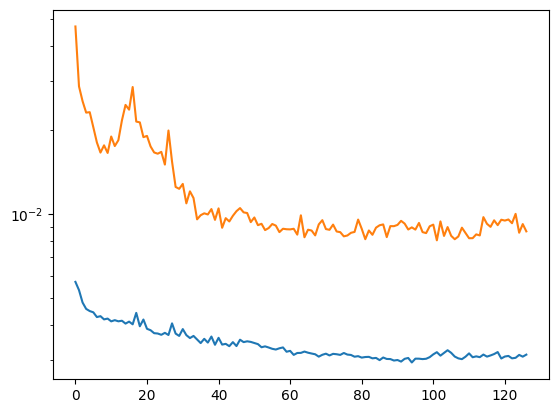

In [16]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [ ]:
# torch.save(model.state_dict(),"model_general")
# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

In [17]:
train_loader = DataLoader(train_combined, batch_size=1, shuffle=False)
df_result_train = list()
k=0

with torch.no_grad():

    for batch in train_loader:

        print("Particle number : ",str(k+1))
        batch.to(device) 

        # Passing the node features and the connection info
        pred = model( batch.x.float() , batch.edge_index, batch.batch)
        df_result_train.append(np.array([batch.y.detach().cpu().numpy()[0][0],pred.detach().cpu().numpy()[0][0]]))    
        clear_output(wait=True)
        k=k+1
        
        # if k==15:
        #     break
    
df_result_train = pd.DataFrame(np.stack(df_result_train),columns=["GT","Pred"])

Particle number :  4256


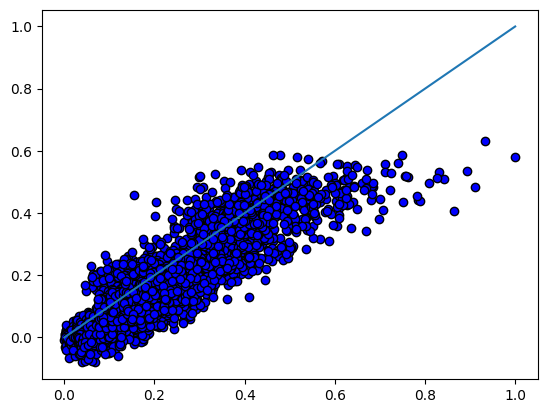

In [18]:
plt.scatter(df_result_train["GT"],df_result_train["Pred"],c="blue",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

In [19]:
test_loader = DataLoader(test_combined, batch_size=1, shuffle=False)
df_result_test = list()
k=0

with torch.no_grad():

    for batch in test_loader:

        print("Particle number : ",str(k+1))
        batch.to(device) 

        # Passing the node features and the connection info
        pred = model( batch.x.float() , batch.edge_index, batch.batch)
        df_result_test.append(np.array([batch.y.detach().cpu().numpy()[0][0],pred.detach().cpu().numpy()[0][0]]))    
        clear_output(wait=True)
        k=k+1

        # if k==10:
        #     break

df_result_test = pd.DataFrame(np.stack(df_result_test),columns=["GT","Pred"])

Particle number :  480


In [20]:
# np.sum((df_result_test["GT"].values - df_result_test["Pred"].values)**2)/len(df_result)

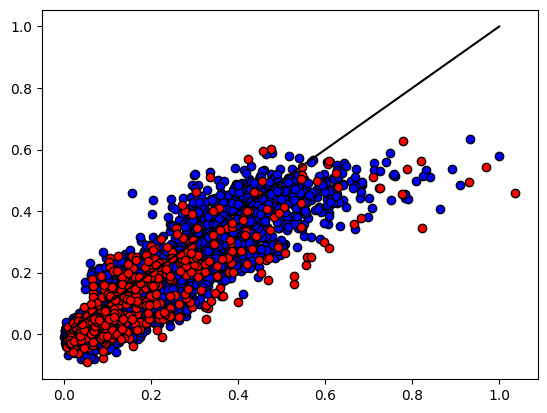

In [21]:
plt.scatter(df_result_train["GT"],df_result_train["Pred"],c="blue",edgecolor='black')
plt.scatter(df_result_test["GT"],df_result_test["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),c='black')

In [ ]:
# attributes = list()
# ### add re column to the data list 
# for i in range(len(data)):
#     indices = list()
#     print("Particle number : ",str(i+1))
#     for value in data[i][0][:,1]:    
#         # Get the row indices where column 'A' has the specified value
#         indices.append( df.index[df['Center_x'] == value].tolist() )
#         attributes.append(df.iloc[indices[0]][["Re","Inclination_angle","Drag_local"]])
#         break
#     break
#     clear_output(wait=True)
    
# ### Concatenating the attrivutes with the data array ###
# # data_with_attributes = [np.concatenate((data[i][0],attributes[i].values),axis=1) for i in range(len(data))]

In [ ]:
### Checking ###
# train_indices = np.arange(2000).astype(int)
# train = [all_dat[train_indices[i]].x for i in range(len(train_indices))]
# train_np = np.vstack(train)

# max_vals = np.max(train_np,axis=0)
# min_vals = np.min(train_np,axis=0)

# train_np_scaled = np.array(train_np - min_vals)/(max_vals-min_vals)
# train_np_scaled.shape

In [ ]:
# ### Rough code to verify conncections ###
# center_shifted = particle_shift(center_10,shift=10)
# points_ref = np.array(center_shifted[["x","y","z"]])
# tree = cKDTree(points_ref)

# ### Choosing a POI on random ###
# n_random = np.random.randint(len(center_10))
# random_poi = np.array(center_10.iloc[n_random][["x","y","z"]])
# print("Particle of interest location and index : ", random_poi, n_random,'\n')

# first_deg = points_ref[tree.query(random_poi,5)[1]]
# points_ref_remaining = array_difference(points_ref,first_deg)

# print("First Deg neighbors \n",first_deg,'\n')
# tree = cKDTree(points_ref_remaining)
# second_deg = points_ref_remaining[tree.query( first_deg[4,:] , 5 )[1]]

# print("Second Deg neighbors \n",second_deg)
# # get_nearest_quick(all_points = points_ref, points_to_exclude  = np.array([]), n_nearest = 1)

In [ ]:
### Rough code to verify scaling ###
# drag_forces = df[ (df["Center_x"]>7.5) & (df["Center_x"]<17.5)]["Drag_local"].values
# train_drags = np.array(drag_forces[train_indices])
# test_drags = np.array(drag_forces[test_indices])
# max_drag,min_drag = train_drags.max(),train_drags.min()

# train_drags = np.array( (train_drags-min_drag)/(max_drag-min_drag))
# test_drags = np.array( (test_drags-min_drag)/(max_drag-min_drag))
# drags_scaled = np.concatenate((train_drags,test_drags))

In [ ]:
# len(data_with_attributes)
# # sf_200 = 
# df_reduced = df[(df["Center_x"]>7.5)&(df["Center_x"]<17.5)]

# drags = df_reduced[(df_reduced["phi"]==10)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

# drags = df_reduced[(df_reduced["phi"]==20)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

# drags = df_reduced[(df_reduced["phi"]==30)&(df_reduced["Re"]==200)]["Drag_local"].values
# print(drags.max()-drags.min(),np.var(drags))

In [ ]:
# from torch_geometric.data import DataLoader
# import warnings
# warnings.filterwarnings("ignore")

# # Root mean squared error
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)  

# # Use GPU for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Wrap data in a data loader
# data_size = len(data)
# NUM_GRAPHS_PER_BATCH = 16

# loader = DataLoader(train_combined, 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# test_loader = DataLoader(test_combined, 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# def train():
#     # Enumerate over the data
#     batch_loss = list()
#     for batch in loader:
#       # Use GPU
#       batch.to(device) 
      
#       # Reset gradients
#       optimizer.zero_grad() 
      
#       # Passing the node features and the connection info
#       pred = model(batch.x.float(), batch.edge_index, batch.batch)
      
#       # Calculating the loss and gradients
#       loss = loss_fn(pred, batch.y)
#       batch_loss.append(loss.item())
#       loss.backward()  
        
#       # Update using the gradients
#       optimizer.step()   
        
#     return np.mean(batch_loss)


# def validate():
#     # Enumerate over the data
    
#     batch_loss = list()
    
#     for batch in test_loader:
      
#       # Use GPU
#       batch.to(device) 

#       # Passing the node features and the connection info
#       pred = model( batch.x.float() , batch.edge_index, batch.batch)
      
#       # Calculating the loss and gradients
#       loss = loss_fn(pred, batch.y) 
#       batch_loss.append(loss.item())
         
#     return np.mean(batch_loss)

# print("Starting training...")
# losses = []
# losses_val = []

# ### Load Checkpoint ###
# # model.load_state_dict(torch.load("model_general"))
# # model = model.to(device)

# for epoch in range(20):
    
#     ### Train ###
#     loss = train()
#     losses.append(loss)

#     ### Val ###
#     loss_val = validate()
#     losses_val.append(loss_val)
    
#     if epoch % 1 == 0:
#       print(f"Epoch {epoch} | Train Loss {losses[-1]}")
#       print(f"Val Loss {losses_val[-1]}")
#       print('\n')
    
# # losses = torch.stack(losses).detach().cpu().numpy()

In [ ]:
# ### Generate dataset corrected ###

# ### Sf=0.1 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_10.values)
# idx = np.stack([tree.query(center_10_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_10_dev))])
# input_dat_sf10 = np.stack([center_shifted_10.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf10 = input_dat_sf10.reshape(input_dat_sf10.shape[0],input_dat_sf10.shape[1]*input_dat_sf10.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf10 = add_const_parameter(input_dat_sf10,0.1)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf10 = np.vstack( ( add_const_parameter(input_dat_sf10,10),
#                    add_const_parameter(input_dat_sf10,50),
#                    add_const_parameter(input_dat_sf10,100),
#                    add_const_parameter(input_dat_sf10,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf10)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf10[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf10 = np.hstack((input_dat_sf10,np.stack(join_additions)))


# ### Sf=0.2 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_20.values)
# idx = np.stack([tree.query(center_20_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_20_dev))])
# input_dat_sf20 = np.stack([center_shifted_20.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf20 = input_dat_sf20.reshape(input_dat_sf20.shape[0],input_dat_sf20.shape[1]*input_dat_sf20.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf20 = add_const_parameter(input_dat_sf20,0.2)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf20 = np.vstack( ( add_const_parameter(input_dat_sf20,10),
#                    add_const_parameter(input_dat_sf20,50),
#                    add_const_parameter(input_dat_sf20,100),
#                    add_const_parameter(input_dat_sf20,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf20)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf20[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf20 = np.hstack((input_dat_sf20,np.stack(join_additions)))


# ### Sf=0.3 ###
# ### Generating the n nearest neighbors ###
# tree = cKDTree(center_shifted_30.values)
# idx = np.stack([tree.query(center_30_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_30_dev))])
# input_dat_sf30 = np.stack([center_shifted_30.iloc[idx[i]] for i in range(len(idx))])
# input_dat_sf30 = input_dat_sf30.reshape(input_dat_sf30.shape[0],input_dat_sf30.shape[1]*input_dat_sf30.shape[2])

# ### Adding solid fraction column ###
# input_dat_sf30 = add_const_parameter(input_dat_sf30,0.3)

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat_sf30 = np.vstack( ( add_const_parameter(input_dat_sf30,10),
#                    add_const_parameter(input_dat_sf30,50),
#                    add_const_parameter(input_dat_sf30,100),
#                    add_const_parameter(input_dat_sf30,200),
#                     ) )

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# join_additions = list()
# for i in range(len(input_dat_sf30)):
#     idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf30[i][[0,1,2,-1]]).all(axis=1) )
#     join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
# input_dat_sf30 = np.hstack((input_dat_sf30,np.stack(join_additions)))

# ### Combining all three solid fractions ###
# all_data = np.vstack((input_dat_sf10,input_dat_sf20,input_dat_sf30))

# ### Converting to DataFrame and renaming the columns ###
# all_data_pd = pd.DataFrame(all_data,columns=["POI_x","POI_y","POI_y",
#                                              "neigh_1_x","neigh_1_y","neigh_1_z",
#                                              "neigh_2_x","neigh_2_y","neigh_2_z",
#                                              "neigh_3_x","neigh_3_y","neigh_3_z",
#                                              "neigh_4_x","neigh_4_y","neigh_4_z",
#                                              "neigh_5_x","neigh_5_y","neigh_5_z",
#                                              "neigh_6_x","neigh_6_y","neigh_6_z",
#                                              "neigh_7_x","neigh_7_y","neigh_7_z",
#                                              "neigh_8_x","neigh_8_y","neigh_8_z",
#                                              "neigh_9_x","neigh_9_y","neigh_9_z",
#                                              "neigh_10_x","neigh_10_y","neigh_10_z",
#                                              "neigh_11_x","neigh_11_y","neigh_11_z",
#                                              "neigh_12_x","neigh_12_y","neigh_12_z",
#                                              "neigh_13_x","neigh_13_y","neigh_13_z",
#                                              "neigh_14_x","neigh_14_y","neigh_14_z",
#                                              "neigh_15_x","neigh_15_y","neigh_16_z",
#                                               "Re","Phi","Inclination_angle","Drag_local"])
# all_data_pd